In [21]:
%matplotlib inline

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_context('notebook')

from lightning.image.controller import ImageController
from lightning_flash import image as flash
from test.resources import demo_resources as demo

# Let's see the ImageController in action:

Since we don't have a database up and running, we will pass the ImageController the information it needs manually. As soon as the database is set up, the Provider will make queries to the database and provide individual ImageControllers the information they need.

## Loading images and creating ImageControl

In [2]:
imcontroller = ImageController(demo.image_info)
demo.image_info.items()

[('IF',
  {'channel_list': ['ER', 'PR', 'HER2'],
   'file_name': {'feature': 'feature_name', 'images': 'image_names'},
   'image_shape': (2048, 2048),
   'path': {'features': ['test/resources/data/013_Quant.csv'],
    'images': ['test/resources/images/ER-allTissue/ER_AFRemoved_013.tif',
     'test/resources/images/PR-allTissue/PR_AFRemoved_013.tif',
     'test/resources/images/HER2-allTissue/Her2_AFRemoved_013.tif']}})]

Normally the image controller would be passed images directly, but for now, we have to load them from disk by calling `generate_im_obj`

In [24]:
imcontroller.generate_image_obj()

Image
mode: local
dtype: uint16
shape: (3, 2048, 2048)

From above, it is possible to inspect basic properties such as whether or not the ImageController's image is running in `local` or `Spark` mode, its type and shape. (3, 2048, 2048) indicates that our image is 2048 x 2048 with 3 channels. Let's look at some of the other information housed by the ImageController:

In [25]:
imcontroller.channels
imcontroller
print('Numerical Labels that index image: ')
print(imcontroller.image_obj.labels)
print('Channels: ')
print(imcontroller.channels)
print('Image types: ' + str(imcontroller.feat_data.keys()))
print ('Features: ')
print(imcontroller.feat_data['IF'].keys())
print('ER features: ')
print(imcontroller.feat_data['IF']['intensity']['ER'].keys())

Numerical Labels that index image: 
[0 1 2]
Channels: 
[('IF', 'ER'), ('IF', 'PR'), ('IF', 'HER2')]
Image types: ['IF']
Features: 
['intensity', 'xy']
ER features: 
['Mem', 'Nuc', 'Cyt']


<b>Question</b>: I am trying to transition from storing data in nested dictionaries to ndarrays - you will notice that I have moved the images to this format but not the features. Thoughts? The image arrays can be stored in an RDD but not the features - I'd like to fix this.

From above we have one imaging modalitity `IF` with three subchanels: `ER`, `PR` and `HER2`. Let's look at the `ER` subchannel:

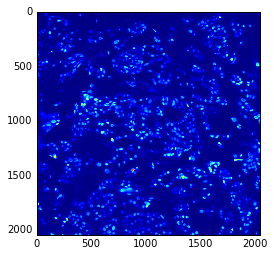

In [16]:
ER = imcontroller.get_image_channel(('IF','ER'))
flash.show_channel(ER) # Note: this is the unadjusted image

### Showing a pseudo-colored image:

Image
mode: local
dtype: uint16
shape: (3, 2048, 2048)


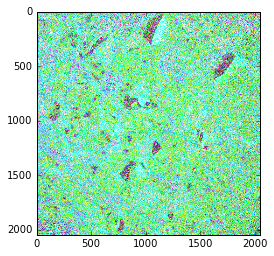

In [26]:
print imcontroller.image_obj
flash.show_first_three_channels(imcontroller.image_obj)

## Patches:

(8, 8, 1, 256, 256, 3)


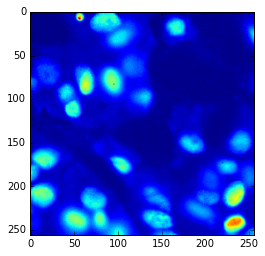

In [28]:
imcontroller.patchify()
print imcontroller.patches.shape
plt.imshow(imcontroller.patches[4,4,0,:,:, 0])
plt.show()
# Note: the error below is due to the fact that I am swapping the axes of the image for a quick fix:


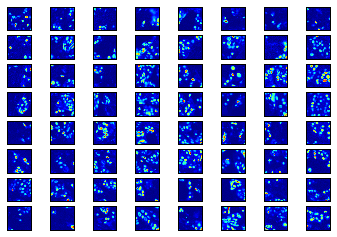

In [19]:
flash.show_subset_patches(imcontroller.patches, (8,8), 0)

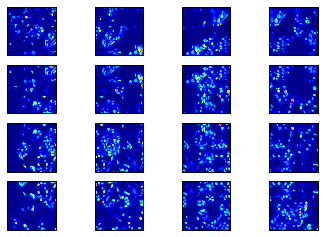

In [20]:
imcontroller.patchify(patch_shape=(512, 512, 3),overlap=200)
flash.show_subset_patches(imcontroller.patches, (4,4), 0)

## ImageController and Spark:

The ImageController will be able to manage images stored in an RDD on Spark:

`from pyspark import SparkContext
sc = SparkContext()`
And then I will add something similar to:

`imcontroller.set_mode('Spark', sc) # change mode and pass SparkContext`


<p class='header-2'>Questions:</p>
<ul class='info-bullet'>
<li>Indexing these image and feature arrays?</li>
<li>Database Schema?</li>
<li>Organization: where should  imtype-specific methods be housed? For example, we may want something like:
`patch.is_informative()` but the implementation of `is_informative` depends on the type of image from which the patch was derived.
</li>
In terms of distributed computing, PySpark seems like a very good way to go:
<li>A lot of computer vision tools are distributed as MATLAB toolboxes. Will these play nicely with the PySpark framework? Will it have to be rewritten? What about MATLAB Compiler Rutime (MCR)?</li>
<li>Matlab just introduced its own distributed computing/cloud computing options...how do those compare?</li>
<li>What about doing registration on the GPU instead of a cluster?</li>
</ul>